# Define Dynamic System Model

In [1]:
from sympy import *


g = 9.81

def f_continuous(X,U,W):
    x,y,z,vx,vy,vz,phi,theta,psi,lx,ly,lz,lp,lq,lr = X
    ax,ay,az,p,q,r = U
    wx,wy,wz,wp,wq,wr = W
    
    # rotation matrix
    Rx = Matrix([[1, 0, 0], [0, cos(phi), -sin(phi)], [0, sin(phi), cos(phi)]])
    Ry = Matrix([[cos(theta), 0, sin(theta)],[0, 1, 0],[-sin(theta), 0, cos(theta)]])
    Rz = Matrix([[cos(psi), -sin(psi), 0],[sin(psi), cos(psi), 0], [0, 0, 1]])
    R = Rz*Ry*Rx
    a_NED = R*Matrix([ax-lx-wx,ay-ly-wy,az-lz-wz])
    
    return Matrix([
        vx,
        vy,
        vz,
        a_NED[0],
        a_NED[1],
        a_NED[2] + g,
        (p-lp-wp) + (q-lq-wq)*sin(phi)*tan(theta) + (r-lr-wr)*cos(phi)*tan(theta),
        (q-lq-wq)*cos(phi) - (r-lr-wr)*sin(phi),
        (q-lq-wq)*sin(phi)/cos(theta) + (r-lr-wr)*cos(phi)/cos(theta),
        0,0,0,0,0,0
    ])

def h(X):
    x,y,z,vx,vy,vz,phi,theta,psi,lx,ly,lz,lp,lq,lr = X
    return Matrix([x,y,z,psi])

# X=Matrix(symbols('x y z v_x v_y v_z phi theta psi l_x l_y l_z l_p l_q l_r'))
X=Matrix(symbols('X[0] X[1] X[2] X[3] X[4] X[5] X[6] X[7] X[8] X[9] X[10] X[11] X[12] X[13] X[14]'))
# U=Matrix(symbols('a_x a_y a_z p q r'))
U=Matrix(symbols('U[0] U[1] U[2] U[3] U[4] U[5]'))
# W=Matrix(symbols('w_x w_y w_z w_p w_q w_r'))
W=Matrix(symbols('W[0] W[1] W[2] W[3] W[4] W[5]'))

dt=symbols('dt')

# discretized dynamics
f = X + f_continuous(X,U,W)*dt

# output function
h = h(X)

# matrices
F = f.jacobian(X)
L = f.jacobian(W)
H = h.jacobian(X)

# substitute W with 0
f = f.subs([(w,0) for w in W])
F = F.subs([(w,0) for w in W])
L = L.subs([(w,0) for w in W])
H = H.subs([(w,0) for w in W])

# extra matrices
symmetric_indexing = lambda i,j: int(i*(i+1)/2+j) if i>=j else int(j*(j+1)/2+i)

P = Matrix([[symbols(f'P[{symmetric_indexing(i,j)}]') for j in range(len(X))] for i in range(len(X))])
Q = Matrix([[symbols(f'Q_diag[{i}]') if i==j else '0' for j in range(len(U))] for i in range(len(U))])
R = Matrix([[symbols(f'R_diag[{i}]') if i==j else '0' for j in range(len(h))] for i in range(len(h))])
Z = Matrix(symbols('Z[0] Z[1] Z[2] Z[3]'))

# Generate EKF code

In [2]:
# from sympy import symbols, sin
from sympy.codegen.ast import CodeBlock, Assignment

# PREDICTION STEP
# state prediction
Xpred = f
# covariance prediction
Ppred = F*P*F.T + L*Q*L.T

# UPDATE STEP
# Residual covariance:
S = H*P*H.T + R
# Kalman gain:
K = P*H.T*S.inverse_LU()
# state update
Xup = X + K*(Z - h)
# covariance update
Pup = (eye(len(X)) - K*H)*P

# assignments
Xpred_assigments = [Assignment(symbols(f'X_new[{i}]'), Xpred[i]) for i in range(len(X))]
Ppred_assigments = [Assignment(symbols(f'P_new[{symmetric_indexing(i,j)}]'), Ppred[i,j]) for i in range(len(X)) for j in range(len(X)) if i >= j] # only the lower diagonal will be calculated

Xup_assigments = [Assignment(symbols(f'X_new[{i}]'), Xup[i]) for i in range(len(X))]
Pup_assigments = [Assignment(symbols(f'P_new[{symmetric_indexing(i,j)}]'), Pup[i,j]) for i in range(len(X)) for j in range(len(X)) if i >= j] # only the lower diagonal will be calculated

# PREDICTION STEP
# code generation
prediction_code = CodeBlock(*Xpred_assigments, *Ppred_assigments)
# common subexpression elimination with tmp variables
prediction_code = prediction_code.cse(optimizations='basic', symbols=(symbols(f'tmp[{i}]') for i in range(10000)))
# simplify
prediction_code = prediction_code.simplify()
# count number of tmp variables
prediction_code_N_tmps = len([s for s in prediction_code.left_hand_sides if s.name.startswith('tmp')])
# generate C code
prediction_code = ccode(prediction_code)

# UPDATE STEP
# code generation
update_code = CodeBlock(*Xup_assigments, *Pup_assigments)
# common subexpression elimination with tmp variables
update_code = update_code.cse(optimizations='basic', symbols=(symbols(f'tmp[{i}]') for i in range(10000)))
# simplify
update_code = update_code.simplify()
# count number of tmp variables
update_code_N_tmps = len([s for s in update_code.left_hand_sides if s.name.startswith('tmp')])
# generate C code
update_code = ccode(update_code)

In [3]:
print('Prediction code:')
print(prediction_code)
print('Update code:')
print(update_code)

Prediction code:
tmp[0] = cos(X[8]);
tmp[1] = cos(X[7]);
tmp[2] = U[0] - X[9];
tmp[3] = tmp[1]*tmp[2];
tmp[4] = U[2] - X[11];
tmp[5] = sin(X[6]);
tmp[6] = sin(X[8]);
tmp[7] = tmp[5]*tmp[6];
tmp[8] = sin(X[7]);
tmp[9] = cos(X[6]);
tmp[10] = tmp[0]*tmp[9];
tmp[11] = tmp[10]*tmp[8] + tmp[7];
tmp[12] = U[1] - X[10];
tmp[13] = tmp[6]*tmp[9];
tmp[14] = tmp[0]*tmp[5];
tmp[15] = -tmp[13] + tmp[14]*tmp[8];
tmp[16] = tmp[0]*tmp[3] + tmp[11]*tmp[4] + tmp[12]*tmp[15];
tmp[17] = dt*tmp[16];
tmp[18] = tmp[10] + tmp[7]*tmp[8];
tmp[19] = -tmp[13]*tmp[8] + tmp[14];
tmp[20] = tmp[12]*tmp[18] - tmp[19]*tmp[4] + tmp[3]*tmp[6];
tmp[21] = dt*tmp[20];
tmp[22] = tmp[12]*tmp[5];
tmp[23] = tmp[4]*tmp[9];
tmp[24] = tmp[1]*tmp[22] + tmp[1]*tmp[23] - tmp[2]*tmp[8];
tmp[25] = tan(X[7]);
tmp[26] = U[4] - X[13];
tmp[27] = tmp[26]*tmp[5];
tmp[28] = U[5] - X[14];
tmp[29] = tmp[28]*tmp[9];
tmp[30] = tmp[26]*tmp[9] - tmp[28]*tmp[5];
tmp[31] = dt*tmp[30];
tmp[32] = 1.0/tmp[1];
tmp[33] = tmp[27] + tmp[29];
tmp[34] = dt*tmp

# Write C code

In [12]:
header = f'''
#ifndef EKF_H
#define EKF_H

#include <stdint.h>

#define N_STATES {len(X)}
#define N_INPUTS {len(U)}
#define N_MEASUREMENTS {len(h)}

void ekf_init(float Q_diag[N_INPUTS], float R_diag[N_MEASUREMENTS], float X0[N_STATES], float P_diag0[N_STATES]);
float* ekf_get_state();
void ekf_predict(float U[N_INPUTS], float dt);
void ekf_update(float Z[N_MEASUREMENTS]);

#endif
'''

prediction_code_ = prediction_code.replace('\n','\n\t')
update_code_ = update_code.replace('\n','\n\t')

source = f'''
#include "ekf.h"
#include <math.h>

// Kalman filter process noise covariance matrix (diagonal)
float ekf_Q_diag[N_INPUTS];

// Kalman filter measurement noise covariance matrix (diagonal)
float ekf_R_diag[N_MEASUREMENTS];

// Kalman filter state
float ekf_X[N_STATES];
float ekf_X_new[N_STATES];

// Kalman filter covariance matrix (lower diagonal) P[i,j] = P_lower_diagonal[i*(i+1)/2+j] (if i>=j)
float ekf_P_lower_diagonal[N_STATES*(N_STATES+1)/2];
float ekf_P_lower_diagonal_new[N_STATES*(N_STATES+1)/2];

// Temporary variables
float tmp[{max(prediction_code_N_tmps,update_code_N_tmps)}];

// pointers
float *X = ekf_X;
float *X_new = ekf_X_new;

float *P = ekf_P_lower_diagonal;
float *P_new = ekf_P_lower_diagonal_new;

float *Q_diag = ekf_Q_diag;
float *R_diag = ekf_R_diag;

// pointer for swapping
float *swap_ptr;

void ekf_init(float Q_diag[N_INPUTS], float R_diag[N_MEASUREMENTS], float X0[N_STATES], float P_diag0[N_STATES]) {{
    // initialize Q and R
    for (int i=0; i<N_INPUTS; i++) {{
        ekf_Q_diag[i] = Q_diag[i];
    }}
    for (int i=0; i<N_MEASUREMENTS; i++) {{
        ekf_R_diag[i] = R_diag[i];
    }}

    // set P to zeros
    for (int i=0; i<N_STATES*(N_STATES+1)/2; i++) {{
        P[i] = 0;
    }}

    // initialize X and P
    for (int i=0; i<N_STATES; i++) {{
        X[i] = X0[i];
        P[i*(i+1)/2+i] = P_diag0[i];
    }}
}}

float* ekf_get_state() {{
    return X;
}}

void ekf_predict(float U[N_INPUTS], float dt) {{
    // PREDICTION STEP X_new, P_new = ...
    {prediction_code_}

    // swap X, X_new and P, P_new pointers
    swap_ptr = X;
    X = X_new;
    X_new = swap_ptr;

    swap_ptr = P;
    P = P_new;
    P_new = swap_ptr;
}}

void ekf_update(float Z[N_MEASUREMENTS]) {{
    // UPDATE STEP X_new, P_new = ...
    {update_code_}

    // swap X, X_new and P, P_new pointers
    swap_ptr = X;
    X = X_new;
    X_new = swap_ptr;

    swap_ptr = P;
    P = P_new;
    P_new = swap_ptr;
}}
'''

with open('c_code/ekf.h','w') as file:
    file.write(header)
with open('c_code/ekf.c','w') as file:
    file.write(source)
    

# Compile C Code

In [13]:
import os
import subprocess
import ctypes
import numpy as np
import importlib
importlib.reload(ctypes)

# Compile C code and create library

# https://cu7ious.medium.com/how-to-use-dynamic-libraries-in-c-46a0f9b98270
path = os.path.abspath('c_code')
# Remove old library
subprocess.call('rm *.so', shell=True, cwd=path)
# Compile object files
subprocess.call('gcc -fPIC -c *.c', shell=True, cwd=path)
# Create library
subprocess.call('gcc -shared -Wl,-soname,libtools.so -o libtools.so *.o', shell=True, cwd=path)
# Remove object files
subprocess.call('rm *.o', shell=True, cwd=path)

lib_path = os.path.abspath("c_code/libtools.so")
lib = ctypes.CDLL(lib_path)

# define argument types 
lib.ekf_init.argtypes = [ctypes.POINTER(ctypes.c_float)]*4
lib.ekf_get_state.restype = ctypes.POINTER(ctypes.c_float)
lib.ekf_predict.argtypes = [ctypes.POINTER(ctypes.c_float), ctypes.c_float]
lib.ekf_update.argtypes = [ctypes.POINTER(ctypes.c_float)]


# Test C code

key= /home/robinferede/quad_gecnet/code/flight_data/TEST02-05/hover_20deg_big.csv_3


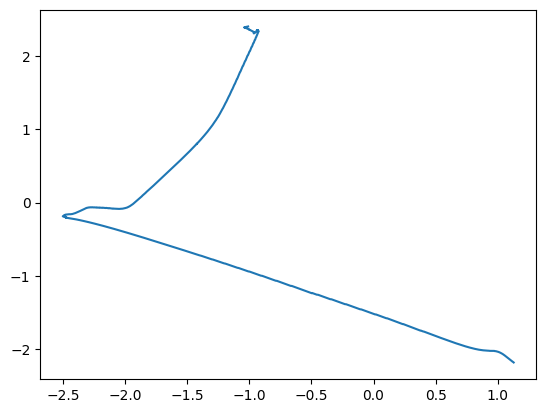

['autopilot_mode', 't', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'phi', 'theta', 'psi', 'ax_raw', 'ay_raw', 'az_raw', 'p_raw', 'q_raw', 'r_raw', 'bias_ax', 'bias_ay', 'bias_az', 'bias_p', 'bias_q', 'bias_r', 'x_opti', 'y_opti', 'z_opti', 'psi_opti', 'u1', 'u2', 'u3', 'u4', 'w1', 'w2', 'w3', 'w4', 'ax', 'ay', 'az', 'p', 'q', 'r', 'v', 'vbx', 'vby', 'vbz']


In [14]:
# load bebop_data
import pickle
import matplotlib.pyplot as plt

bebop_data = {}
with open('bebop_data.pickle','rb') as file:
    bebop_data = pickle.load(file)

# get data from key
index = 6
key = list(bebop_data.keys())[index]
data = bebop_data[key]
print('key=',key)

# plot trajectory
plt.plot(data['x'], data['y'])
plt.show()

# EKF INPUT: U = [ax, ay, az, p, q, r] (IMU)
U_data = np.array([
    data['ax_raw'], data['ay_raw'], data['az_raw'], data['p_raw'], data['q_raw'], data['r_raw']
]).T

# EKF MEASUREMENT: Z = [x, y, z, psi] (Optitrack)
Z_data = np.array([
    data['x_opti'], data['y_opti'], data['z_opti'], data['psi_opti']
]).T

# EKF STATE: X = [x, y, z, vx, vy, vz, phi, theta, psi, bias_ax, bias_ay, bias_az, bias_p, bias_q, bias_r] (Onboard EKF)
X_data = np.array([
    data['x'], data['y'], data['z'], data['vx'], data['vy'], data['vz'], data['phi'], data['theta'], data['psi'], data['bias_ax'], data['bias_ay'], data['bias_az'], data['bias_p'], data['bias_q'], data['bias_r']
]).T

t = data['t']
print(list(data.keys()))

In [50]:
# INITIALIZE EKF
# initial state
X_init = np.zeros(len(X))
X_init[:3] = Z_data[0,:3]
X_init[8]  = Z_data[0,3]

# initial covariance
P_init = np.array([1.]*len(X))

# process noise covariance
Q_diag = np.array([0.5, 0.5, 0.5, 0.01, 0.01, 0.01])

# measurement noise covariance
R_diag = np.array([0.001, 0.001, 0.001, 0.1])

lib.ekf_init(
    (ctypes.c_float*len(Q_diag))(*Q_diag),
    (ctypes.c_float*len(R_diag))(*R_diag),
    (ctypes.c_float*len(X_init))(*X_init),
    (ctypes.c_float*len(P_init))(*P_init)
)

# test ekf_get_state
x = lib.ekf_get_state()
x = np.array([x[i] for i in range(len(X))])
print(x)

# RUN EKF
# X_list = [X_init]

# for i in range(1, len(t)):
#     # PREDICT
#     lib.ekf_predict(
#         (ctypes.c_float*len(U_data[i]))(*U_data[i]),
#         ctypes.c_float(t[i]-t[i-1])
#     )
    
#     # UPDATE
#     # only update when there is a new measurement
#     if Z_data[i][0] != Z_data[i-1][0]:
#         lib.ekf_update(
#             (ctypes.c_float*len(Z_data[i]))(*Z_data[i])
#         )
    
#     # get state
#     x = lib.ekf_get_state()
#     x = np.array([x[i] for i in range(len(X))])
#     X_list.append(x)


[ 1.17282116 -2.23363829 -0.30052355  1.07895625 -1.39994216  0.32797357
  0.19119073 -0.03298585  0.0040583  -0.05885437  0.45703086 -0.0517767
  0.04601146 -0.02268079  0.03556623]


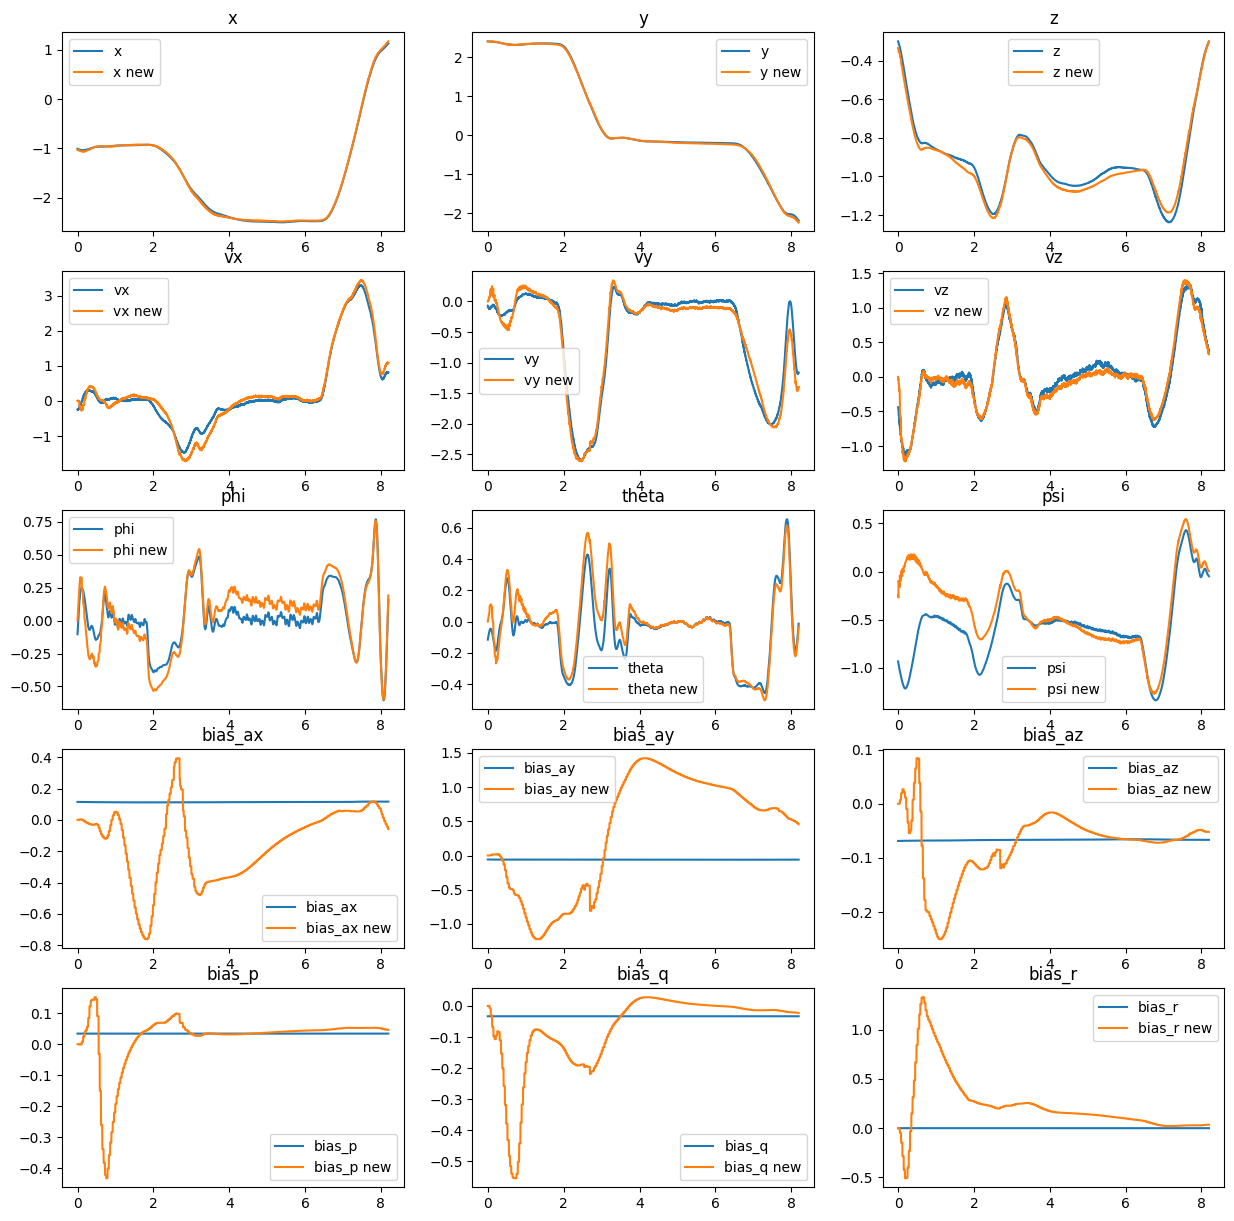

In [22]:
# plot trajectory
X_list = np.array(X_list)

names = 'x, y, z, vx, vy, vz, phi, theta, psi, bias_ax, bias_ay, bias_az, bias_p, bias_q, bias_r'.split(', ')

# 5x3 subplots
fig, axs = plt.subplots(5, 3, figsize=(15,15))
axs = axs.flatten()
for i in range(len(X)):
    axs[i].plot(t, X_data[:,i], label=names[i])
    axs[i].plot(t, X_list[:,i], label=names[i]+' new')
    axs[i].set_title(names[i])
    axs[i].legend()
plt.show()